In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.simplefilter('ignore')
plt.style.use('ggplot')

c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\pc\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
ocean_discord = pd.read_csv('data/oceandiscord.csv')
ocean_discord['Date'] = pd.to_datetime(ocean_discord['Date'].astype(str).str[:10]) #just days
ocean_discord['message_count'] = 1

ocean_price = pd.read_csv('data/OCEAN-USD_price_data.csv')
ocean_price['Date'] = pd.to_datetime(ocean_price['Date'].astype(str).str[:10])


In [142]:
ocean_discord.Date.min(), ocean_discord.Date.max()

(Timestamp('2019-08-20 00:00:00'), Timestamp('2024-02-20 00:00:00'))

In [143]:
ocean_price.Date.min(), ocean_price.Date.max()

(Timestamp('2019-05-06 00:00:00'), Timestamp('2024-02-24 00:00:00'))

In [4]:
ocean_price = ocean_price[ocean_price.Date >= '2019-08-20']
ocean_price = ocean_price[ocean_price.Date <= '2024-02-20']
ocean_price.reset_index(drop=True, inplace=True)
ocean_price.Date.min(), ocean_price.Date.max()

(Timestamp('2019-08-20 00:00:00'), Timestamp('2024-02-20 00:00:00'))

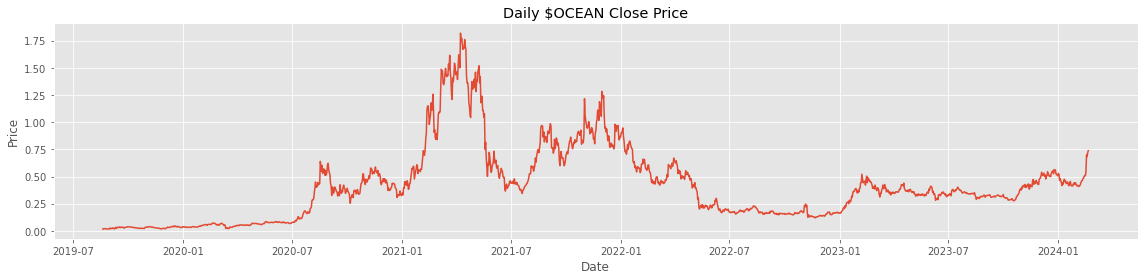

In [145]:
dates = ocean_price['Date'].to_numpy()
closing_price = ocean_price['Close'].to_numpy()

plt.figure(figsize = (16,4))
plt.plot(dates, closing_price)
plt.title('Daily $OCEAN Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [192]:
welcome_bot = 159985870458322944
welcome_channel = 'Ocean Protocol - GET STARTED - 👋︱welcome [727898674637832274]'

In [214]:

# Identify the first message sent by each user in the welcome channel
first_messages = ocean_discord[ocean_discord['Channel'] == welcome_channel].groupby('AuthorID')['Date'].min().reset_index()
first_messages = first_messages[first_messages['AuthorID'] != welcome_bot]
first_messages.columns = ['AuthorID', 'First_Message_Date']

# Merge the first message information with the original DataFrame
users_activity = pd.merge(ocean_discord, first_messages, on='AuthorID', how='left')

# Create a binary variable to indicate whether a message is the first message sent by each user
users_activity['Is_New_User'] = ((users_activity['Channel'] == welcome_channel) & (users_activity['Date'] == users_activity['First_Message_Date']))

# Sum this variable over time to track the cumulative number of new users
daily_new_users = users_activity.groupby(users_activity['Date'].dt.date)['Is_New_User'].sum().reset_index(name='Daily_New_Users')

In [217]:
# Define rule for active users (e.g., users who sent at least 3 messages per day)
active_users_threshold = 3
users_activity['Active_User'] = users_activity.groupby([users_activity['Date'].dt.date, 'AuthorID'])['Content'].transform('count') >= active_users_threshold

# Calculate daily active users
daily_active_users = users_activity.groupby(users_activity['Date'].dt.date)['Active_User'].sum().reset_index(name='Daily_Active_Users')


In [221]:
message_per_day = ocean_discord.groupby([pd.Grouper(key='Date', freq='D')]).size().reset_index(name='Message_Count')


In [222]:
daily_new_users['Date'] = pd.to_datetime(daily_new_users['Date'])
daily_active_users['Date'] = pd.to_datetime(daily_active_users['Date'])
message_per_day['Date'] = pd.to_datetime(message_per_day['Date'])

In [244]:

df_correlations = ocean_price[['Date', 'Close']]

df_correlations = pd.merge(df_correlations, daily_active_users,
                           on = 'Date', how = 'left')
df_correlations = pd.merge(df_correlations, daily_new_users,
                           on = 'Date', how = 'left')
df_correlations = pd.merge(df_correlations, message_per_day,
                           on = 'Date', how = 'left')

df_correlations.fillna(0, inplace=True)

In [245]:
df0 = df_correlations
df0['Close'] = df0['Close'] * 100
df0

,Date,Close,Daily_Active_Users,Daily_New_Users,Message_Count
0,2019-08-20,1.764500,0.0,0.0,3
1,2019-08-21,1.746700,0.0,0.0,2
2,2019-08-22,2.083000,0.0,0.0,16
3,2019-08-23,2.047900,0.0,0.0,1
4,2019-08-24,1.970500,0.0,0.0,1
...,...,...,...,...,...
1641,2024-02-16,53.621101,5.0,0.0,13
1642,2024-02-17,69.852799,4.0,1.0,16
1643,2024-02-18,68.288600,29.0,1.0,44
1644,2024-02-19,72.092098,26.0,0.0,51


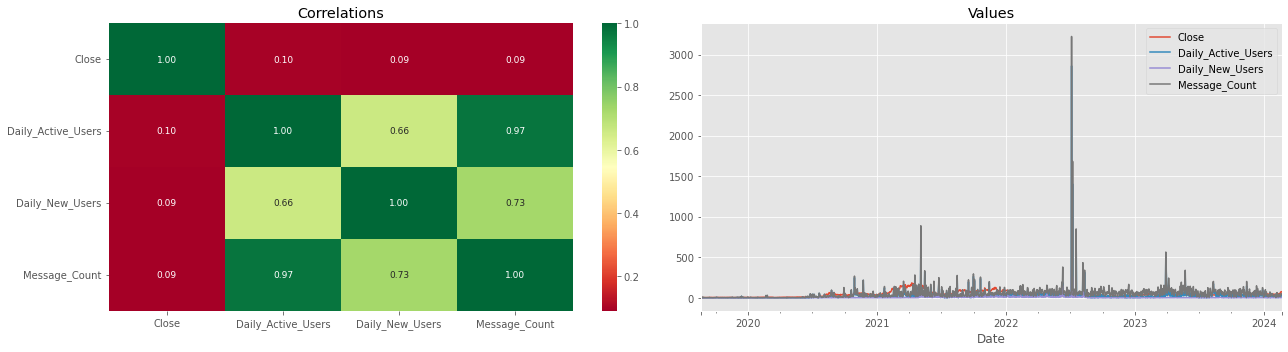

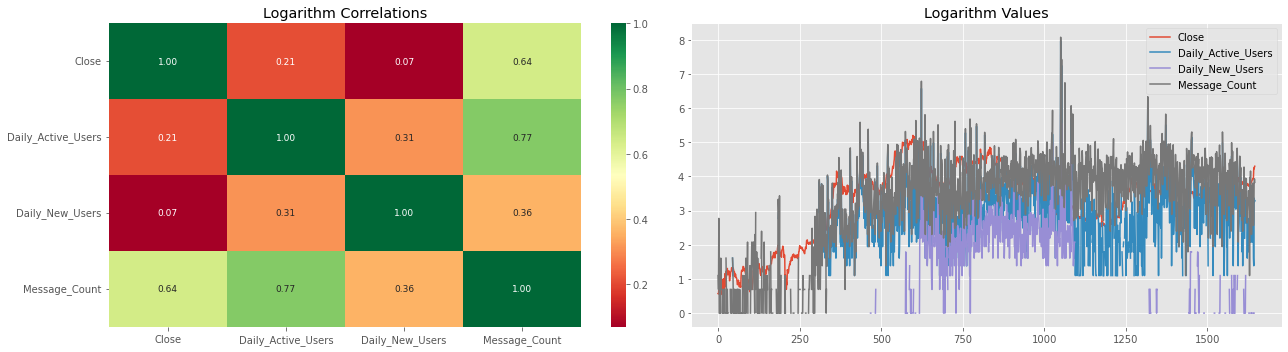

In [246]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.heatmap(df0.drop(columns=['Date']).corr(), ax=axes[0], cmap='RdYlGn', annot=True, fmt='.2f', annot_kws={"size": 9})
axes[0].set_title('Correlations')
df0.plot(ax=axes[1], title='Values', x='Date')
plt.tight_layout()


# Create subplots 
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot correlation heatmap for logarithmic values
sns.heatmap(np.log(df0.drop(columns=['Date'])).corr(), ax=axes[0], cmap='RdYlGn', annot=True, fmt='.2f', annot_kws={"size": 9})
axes[0].set_title('Logarithm Correlations')

# Plot logarithmic values
np.log(df0.drop(columns=['Date'])).plot(ax=axes[1], title='Logarithm Values')
# Adjust layout
plt.tight_layout()
# Show plots
plt.show()

In [7]:
# Community Questions
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

ocean_discord['Is_Question'] = ocean_discord['Content'].apply(lambda x: '?' in sent_tokenize(x)[-1] if isinstance(x, str) else np.nan)

# Count the number of identified questions
question_count = ocean_discord['Is_Question'].sum()

# Print the count of identified questions
print("Total number of identified questions:", question_count)

# Example: Display some of the identified questions
print("Some examples of identified questions:")
print(ocean_discord[ocean_discord['Is_Question'] == True]['Content'][7])
print(ocean_discord[ocean_discord['Is_Question'] == True]['Content'][19])
print(ocean_discord[ocean_discord['Is_Question'] == True]['Content'][22])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total number of identified questions: 5539
Some examples of identified questions:
Anyone tried transfer dataNFT ownership to a safe multisig wallet and set the minter role after the transfer?
I saw there is WIP PR to replace web3.js with ethers.js in ocean .js. Do we know how far it is to be merged?
Anyone knows where to get DAI on Mumbai testnet?


In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

# Text Preprocessing
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

def preprocess_text(text):
    if pd.isna(text):  # Check if text is NaN
        return []
    tokens = word_tokenize(str(text).lower())  # Convert to string and then lowercase
    tokens = [porter.stem(token) for token in tokens if token.isalnum()]  # Stemming and remove non-alphanumeric tokens
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    return tokens

ocean_questions = ocean_discord[ocean_discord['Is_Question'] == True]
ocean_questions.reset_index(drop=True, inplace=True)

ocean_questions['Tokens'] = ocean_questions['Content'].apply(preprocess_text)

# Identify Frequently Asked Questions
all_tokens = [token for tokens in ocean_questions['Tokens'] for token in tokens]
faq_counter = Counter(all_tokens)
most_common_faq = faq_counter.most_common(20)  # Get top 20 most common words

In [285]:
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
# Manual categorization:
technical_keywords = ['error', 'problem', 'issue', 'bug', 
                      'fix', 'testnet', 'mumbai', 'wallet',
                      'build', 'framework', 'setup', 'test', 
                      'develop', 'request', 'instal', 'repo',
                      'github', 'aw', 's3', 'bucket']
price_related_keywords = ['price', 'market', 'value', 'token',
                          'coin', 'buy', 'sell', 'trade']
general_info_keywords = ['how', 'what', 'when', 'where',
                          'why', 'ocean', 'protocol', 'ether',
                          'minter', 'data', 'marketplac', 'crypto',
                          'web3', 'earn']

# Default category for words not found in any list
default_category = 'Other'


# Function to categorize questions based on predefined keyword lists with fuzzy matching
def categorize_question(content):
    content_lower = content.lower()
    matches = {
        'Technical': process.extractOne(content_lower, technical_keywords, scorer=fuzz.token_set_ratio),
        'Price-Related': process.extractOne(content_lower, price_related_keywords, scorer=fuzz.token_set_ratio),
        'General Information': process.extractOne(content_lower, general_info_keywords, scorer=fuzz.token_set_ratio)
    }
    best_match, score = max(matches.items(), key=lambda x: x[1][1])
    score = score[1]
    if score >= 80:  # Minimum threshold for fuzzy matching score
        return best_match
    else:
        return default_category  # Assign to default category if no suitable match is found

# Apply categorization function to identify categories for questions
ocean_questions['Question_Category'] = ocean_questions[ocean_questions['Is_Question']]['Content'].apply(categorize_question)

# Count the number of questions in each category
question_category_counts = ocean_questions['Question_Category'].value_counts()

# Print the count of questions in each category
print("Question Category Counts:")
print(question_category_counts)

Question Category Counts:
Question_Category
General Information    2522
Other                  2122
Price-Related           453
Technical               442
Name: count, dtype: int64


In [30]:
## Comunity Activity
ocean_discord = pd.read_pickle('data/ocean_discord.pkl')

messages = ocean_discord.groupby('Author').agg({
    'message_count': sum, 
    'Attachment_Count': sum, 
    'Reactions_Count': sum
}).reset_index().sort_values('message_count', ascending = False)

attachments = ocean_discord.groupby('Author').agg({
    'message_count': sum, 
    'Attachment_Count': sum, 
    'Reactions_Count': sum
}).reset_index().sort_values('Attachment_Count', ascending = False)

reactions = ocean_discord.groupby('Author').agg({
    'message_count': sum, 
    'Attachment_Count': sum, 
    'Reactions_Count': sum
}).reset_index().sort_values('Reactions_Count', ascending = False)

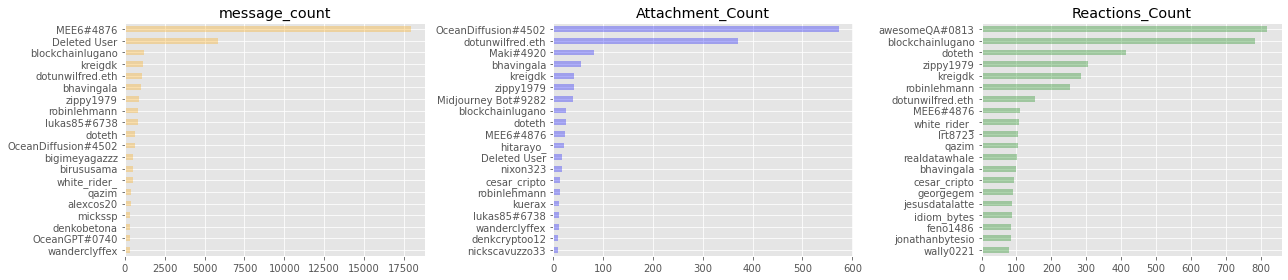

In [47]:
# numeric features distributions
_, ax = plt.subplots(1,3, figsize = (18,4))

features = ocean_discord.groupby('Author').agg({
    'message_count': sum, 
    'Attachment_Count': sum, 
    'Reactions_Count': sum
}).reset_index().sort_values('message_count', ascending = False)

colors = ['orange','blue','green']
feats = list(features.columns)[1:]
for i,f in enumerate(feats):
    x = features.sort_values(f, ascending = False).set_index('Author')[f]
    _ = x[:20].sort_values().plot(ax = ax[i], kind = 'barh', alpha = 0.3, color = colors[i], title = f, ylabel = '')
plt.tight_layout()

In [63]:
# Define a function to calculate Reactions_Count
def get_words_count(content):
    if isinstance(content, str):
        return len(content.split())
    else:
        return 0

def get_characters_count(content):
    if isinstance(content, str):
        return len(content)
    else:
        return 0

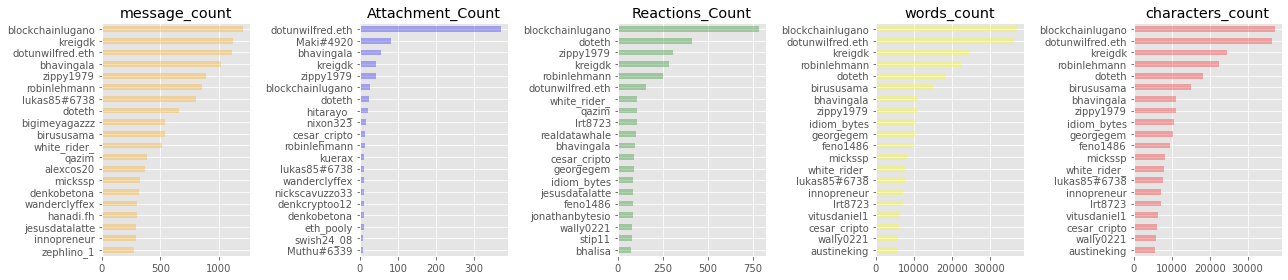

In [159]:
bots_users = ['MEE6#4876', 'Deleted User', 'OceanDiffusion#4502',	
            'GitHub', 'OceanGPT#0740', 'awesomeQA#0813',	
            'Midjourney Bot#9282', 'AutoBot#1760', 'Ocean Protocol • TweetShift',
            'Application Bot Premium#7743', 'MEE6', 'TweetShift#4434']

# We remove the authors which have been considered as bots
ocean_users = ocean_discord[~ocean_discord['Author'].isin(bots_users)]

ocean_users['words_count'] = ocean_users['Content'].apply(get_words_count)
ocean_users['characters_count'] = ocean_users['Content'].apply(get_characters_count)

features = ocean_users.groupby('Author').agg({
    'message_count': sum, 
    'Attachment_Count': sum, 
    'Reactions_Count': sum,
    'words_count': sum,
    'characters_count': sum
}).reset_index().sort_values('message_count', ascending = False)


# numeric features distributions
_, ax = plt.subplots(1,5, figsize = (18,4))

colors = ['orange','blue','green', 'yellow', 'red']
feats = list(features.columns)[1:]
for i,f in enumerate(feats):
    x = features.sort_values(f, ascending = False).set_index('Author')[f]
    _ = x[:20].sort_values().plot(ax = ax[i], kind = 'barh', alpha = 0.3, color = colors[i], title = f, ylabel = '')
plt.tight_layout()

In [160]:
# Extract time of day and day of week
ocean_users['Hour'] = ocean_users['Date'].dt.hour
ocean_users['Day_of_Week'] = ocean_users['Date'].dt.dayofweek  # Monday=0, Sunday=6

# Analyze peak activity
peak_activity_hour_messages = ocean_users.groupby('Hour')['message_count'].sum()
peak_activity_day_messages = ocean_users.groupby('Day_of_Week')['message_count'].sum()

peak_activity_hour_attachments = ocean_users.groupby('Hour')['Attachment_Count'].sum()
peak_activity_day_attachments = ocean_users.groupby('Day_of_Week')['Attachment_Count'].sum()


peak_activity_hour_reactions = ocean_users.groupby('Hour')['Reactions_Count'].sum()
peak_activity_day_reactions = ocean_users.groupby('Day_of_Week')['Reactions_Count'].sum()



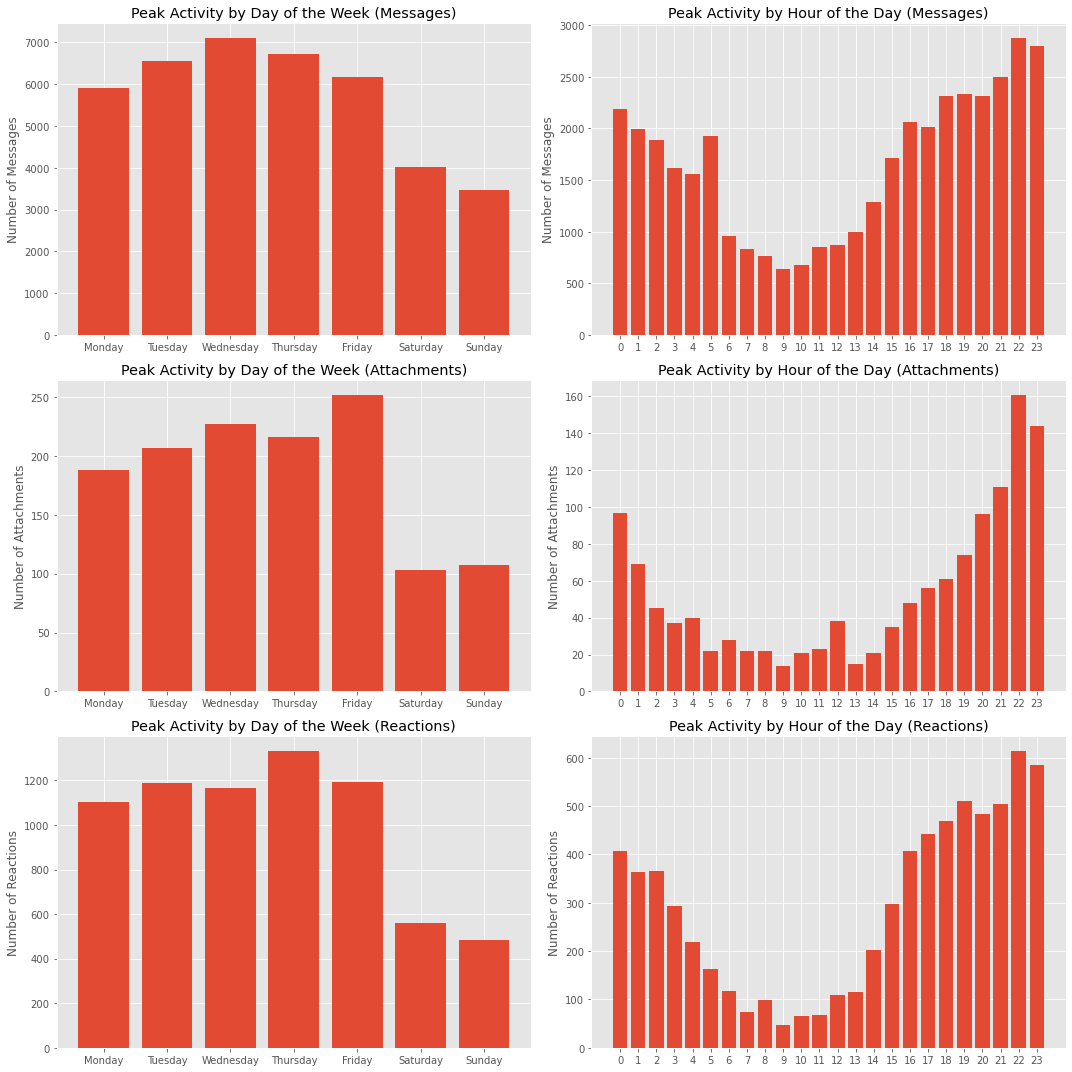

In [161]:
# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot peak activity by messages
axes[0, 0].bar(peak_activity_day_messages.index, peak_activity_day_messages.values)
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[0, 0].set_ylabel('Number of Messages')
axes[0, 0].set_title('Peak Activity by Day of the Week (Messages)')

axes[0, 1].bar(peak_activity_hour_messages.index, peak_activity_hour_messages.values)
axes[0, 1].set_xticks(range(24))
axes[0, 1].set_ylabel('Number of Messages')
axes[0, 1].set_title('Peak Activity by Hour of the Day (Messages)')

# Plot peak activity by attachments
axes[1, 0].bar(peak_activity_day_attachments.index, peak_activity_day_attachments.values)
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[1, 0].set_ylabel('Number of Attachments')
axes[1, 0].set_title('Peak Activity by Day of the Week (Attachments)')


axes[1, 1].bar(peak_activity_hour_attachments.index, peak_activity_hour_attachments.values)
axes[1, 1].set_xticks(range(24))
axes[1, 1].set_ylabel('Number of Attachments')
axes[1, 1].set_title('Peak Activity by Hour of the Day (Attachments)')

# Plot peak activity by reactions
axes[2, 0].bar(peak_activity_day_reactions.index, peak_activity_day_reactions.values)
axes[2, 0].set_xticks(range(7))
axes[2, 0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[2, 0].set_ylabel('Number of Reactions')
axes[2, 0].set_title('Peak Activity by Day of the Week (Reactions)')


axes[2, 1].bar(peak_activity_hour_reactions.index, peak_activity_hour_reactions.values)
axes[2, 1].set_xticks(range(24))
axes[2, 1].set_ylabel('Number of Reactions')
axes[2, 1].set_title('Peak Activity by Hour of the Day (Reactions)')



plt.tight_layout()

In [162]:
# Calculate participation rate
total_messages = features['message_count'].sum()
total_attachments = features['Attachment_Count'].sum()
total_reaction = features['Reactions_Count'].sum()

features['message_rate'] = features['message_count'] / total_messages
features['attachment_rate'] = features['Attachment_Count'] / total_attachments
features['reaction_rate'] = features['Reactions_Count'] / total_reaction

features['Participation_Rate'] = features['message_rate'] + features['attachment_rate'] + features['reaction_rate']
print(f'The minimum rate is {features.Participation_Rate.min()} and the maximum rate is {features.Participation_Rate.max()}')



The minimum rate is 0.0 and the maximum rate is 0.3343909495273425


In [163]:
# Classify users based on participation rate
def classify_participation_rate(rate):
    if rate < 0.05:
        return 'Low Participant'
    elif rate < 0.1:
        return 'Moderate Participant'
    else:
        return 'High Participant'
    
features['Participation_Class'] = features['Participation_Rate'].apply(classify_participation_rate)

In [164]:
from tabulate import tabulate
top10 = features.sort_values('Participation_Rate', ascending=False).reset_index(drop=True)[:10][['Author', 'Participation_Class']]

data = top10.values.tolist()

# Get column headers
headers = top10.columns.tolist()

print(f'The top 10 users by Participation rate are:')
print(tabulate(data, headers=headers, tablefmt='pretty'))


The top 10 users by Participation rate are:
+------------------+----------------------+
|      Author      | Participation_Class  |
+------------------+----------------------+
| dotunwilfred.eth |   High Participant   |
| blockchainlugano |   High Participant   |
|     kreigdk      |   High Participant   |
|    zippy1979     | Moderate Participant |
|      doteth      | Moderate Participant |
|    bhavingala    | Moderate Participant |
|   robinlehmann   | Moderate Participant |
|    Maki#4920     | Moderate Participant |
|   lukas85#6738   |   Low Participant    |
|   white_rider_   |   Low Participant    |
+------------------+----------------------+


In [165]:
print(f'The minimum messages are {features.message_count.min()} and the maximum number of messages is {features.message_count.max()}')

The minimum messages are 0 and the maximum number of messages is 1205


In [166]:
# Classify users based on total message count
def classify_total_messages(count):
    if count < 100:
        return 'Low Activity'
    elif count < 700:
        return 'Moderate Activity'
    else:
        return 'High Activity'

features['Total_Messages_Class'] = pd.cut(features['message_count'], bins=[0, 100, 700, float('inf')], labels=['Low Activity', 'Moderate Activity', 'High Activity'])


In [167]:
top10 = features.sort_values('message_count', ascending=False).reset_index(drop=True)[:10][['Author', 'Total_Messages_Class']]

data = top10.values.tolist()

# Get column headers
headers = top10.columns.tolist()

print(f'The top 10 users by Message sent:')
print(tabulate(data, headers=headers, tablefmt='pretty'))


The top 10 users by Message sent:
+------------------+----------------------+
|      Author      | Total_Messages_Class |
+------------------+----------------------+
| blockchainlugano |    High Activity     |
|     kreigdk      |    High Activity     |
| dotunwilfred.eth |    High Activity     |
|    bhavingala    |    High Activity     |
|    zippy1979     |    High Activity     |
|   robinlehmann   |    High Activity     |
|   lukas85#6738   |    High Activity     |
|      doteth      |  Moderate Activity   |
|  bigimeyagazzz   |  Moderate Activity   |
|    birususama    |  Moderate Activity   |
+------------------+----------------------+


In [44]:
## Technical Issues
technical_keywords = [
    'error', 'issue', 'problem', 'bug', 'crash', 'failure', 'warning', 'exception', 'malfunction', 'breakdown',
    'connection', 'network', 'internet', 'server', 'offline', 'timeout', 'latency', 'bandwidth', 'firewall',
    'slow', 'lag', 'freeze', 'hang', 'delay', 'bottleneck', 'overload',
    'display', 'layout', 'formatting', 'alignment', 'rendering', 'appearance', 'visibility',
    'feature', 'function', 'capability', 'behavior', 'operation', 'functionality',
    'compatibility', 'interoperability', 'integration', 'version', 'update', 'upgrade',
    'security', 'vulnerability', 'breach', 'exploit', 'unauthorized', 'permission',
    'memory', 'CPU', 'disk', 'storage', 'resource', 'utilization',
    'log', 'monitoring', 'analytics', 'metrics', 'audit', 'trace',
    'API', 'third-party', 'external service', 'integration'
]
ocean_discord['Content'] = ocean_discord['Content'].fillna('')
ocean_discord['Split_Content'] = ocean_discord['Content'].str.lower().str.split()
ocean_discord_tech = ocean_discord[ocean_discord['Channel'] != 'Ocean Protocol - ECOSYSTEM - 🎨︱ai-fun [1088460971191832616]']

# Identify messages containing technical keywords
technical_messages = ocean_discord_tech[ocean_discord_tech['Split_Content'].apply(lambda x: any(word in x for word in technical_keywords))]

# Categorize identified issues based on potential sources
user_related = technical_messages[technical_messages['Content'].apply(lambda x: any(word in x for word in ['user']))]
system_related = technical_messages[technical_messages['Content'].apply(lambda x: any(word in x for word in ['system', 'server', 'software']))]
external_factors = technical_messages[~technical_messages.index.isin(user_related.index)]
external_factors = external_factors[~external_factors.index.isin(system_related.index)]
# Print statistics and insights
print("Total Technical Issues:", len(technical_messages))
print("User-Related Issues:", len(user_related))
print("System-Related Issues:", len(system_related))
print("External Factors:", len(external_factors))

Total Technical Issues: 1863
User-Related Issues: 169
System-Related Issues: 307
External Factors: 1436
